In [1]:
import matplotlib.pyplot as plt
import numpy as np
import numpy.linalg as nplin
import itertools

In [2]:
np.random.seed(0)

In [3]:
def operators(s):
    #generate terms in the energy function
    n_seq,n_var = s.shape
    ops = np.zeros((n_seq,n_var+int(n_var*(n_var-1)/2.0)))

    jindex = 0
    for index in range(n_var):
        ops[:,jindex] = s[:,index]
        jindex +=1

    for index in range(n_var-1):
        for index1 in range(index+1,n_var):
            ops[:,jindex] = s[:,index]*s[:,index1]
            jindex +=1
            
    return ops

In [4]:
def energy_ops(ops,w):
    return np.sum(ops*w[np.newaxis,:],axis=1)

In [5]:
def generate_seqs(n_var,n_seq,n_sample=30,g=1.0):
    samples = np.random.choice([1.0,-1.0],size=(n_seq*n_sample,n_var),replace=True)
    ops = operators(samples)
    n_ops = ops.shape[1]

    w_true = g*(np.random.rand(ops.shape[1])-0.5)/np.sqrt(float(n_var))
    #w_true = np.random.normal(0.,g/np.sqrt(n_var),size=n_ops)

    sample_energy = energy_ops(ops,w_true)
    p = np.exp(sample_energy)
    p /= np.sum(p)
    out_samples = np.random.choice(np.arange(n_seq*n_sample),size=n_seq,replace=True,p=p)
    
    return w_true,samples[out_samples] #,p[out_samples],sample_energy[out_samples]

In [6]:
def eps_machine(s,eps_scale=0.1,max_iter=151,alpha=0.1):
    MSE = np.zeros(max_iter)
    KL = np.zeros(max_iter)
    E_av = np.zeros(max_iter)
    
    n_seq,n_var = s.shape
    ops = operators(s)
    n_ops = ops.shape[1]
    cov_inv = np.eye(ops.shape[1])

    np.random.seed(13)
    w = np.random.rand(n_ops)-0.5    
    
    w_iter = np.zeros((max_iter,n_ops))
    for i in range(max_iter): 
        
        eps_scale = np.random.rand()/np.max([1.,np.max(np.abs(w))])
        
        energies_w = energy_ops(ops,w)
        probs_w = np.exp(-energies_w*(1-eps_scale))
        z_data = np.sum(probs_w)
        probs_w /= z_data
        ops_expect_w = np.sum(probs_w[:,np.newaxis]*ops,axis=0)
        
        #if iterate%int(max_iter/5.0)==0:
        E_exp = (probs_w*energies_w).sum()
        KL[i] = -E_exp - np.log(z_data) + np.sum(np.log(np.cosh(w*eps_scale))) + n_var*np.log(2.)
        
        E_av[i] = energies_w.mean()
        MSE[i] = ((w-w_true)**2).mean()
        #print(RMSE[i])
        #print(eps_scale,iterate,nplin.norm(w-w_true),RMSE,KL,E_av)
        sec_order = w*eps_scale
        w += alpha*cov_inv.dot((ops_expect_w - sec_order))        
        #print('final ',eps_scale,iterate,nplin.norm(w-w_true))    
        w_iter[i,:] = w
        
    return MSE,KL,E_av,w_iter

In [7]:
def hopfield_model(s):
    ops = operators(s)
    w = np.mean(ops,axis=0)
    #print('hopfield error ',nplin.norm(w-w_true))
    return w

In [8]:
def boltzmann_machine_exact(s,s_all,max_iter=150,alpha=5e-2,cov=False):
    n_seq,n_var = s.shape
    ops = operators(s)
    cov_inv = np.eye(ops.shape[1])
    ops_obs = np.mean(ops,axis=0)
    ops_model = operators(s_all)

    n_ops = ops.shape[1]
    
    np.random.seed(13)
    w = np.random.rand(n_ops)-0.5    
    for iterate in range(max_iter):
        energies_w = energy_ops(ops_model,w)
        probs_w = np.exp(energies_w)
        probs_w /= np.sum(probs_w)
        if iterate%10 == 0: 
            #print(iterate,nplin.norm(w-w_true)) #,nplin.norm(spin_cov_w-spin_cov_obs))
            MSE = ((w-w_true)**2).mean()
            print(iterate,MSE)
            
        w += alpha*cov_inv.dot(ops_obs - np.sum(ops_model*probs_w[:,np.newaxis],axis=0))

    print('final',iterate,MSE)

    return w

In [9]:
max_iter = 151

n_var,n_seq = 100,10000
g = 2.

w_true,seqs = generate_seqs(n_var,n_seq,g=g)
#s_all = np.asarray(list(itertools.product([1.0, -1.0], repeat=n_var)))
#s_all.shape

In [10]:
print('Hopfield:')
w1 = hopfield_model(seqs)

print(((w1-w_true)**2).mean())

Hopfield:
0.06628274530952638


In [11]:
#print('Boltzmann (exact):')
#w2 = boltzmann_machine_exact(seqs,s_all,cov=False)

In [12]:
MSE,KL,E_av,w = eps_machine(seqs,eps_scale=0.1,max_iter=max_iter)

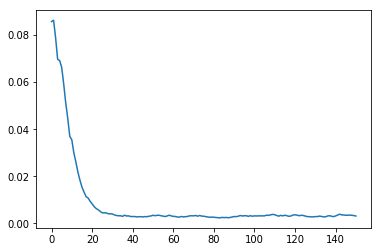

In [13]:
plt.plot(MSE)

In [14]:
MSEmin = min(MSE)
MSEmin

0.00235301974669398

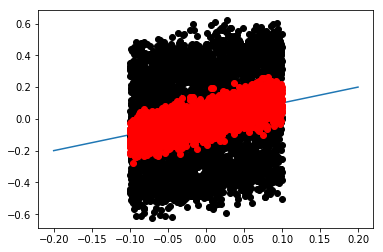

In [18]:
plt.plot([-0.2,0.2],[-0.2,0.2])
plt.plot(w_true,w1,'ko')
plt.plot(w_true,w[-1],'ro')

In [19]:
np.savetxt('w_n100_l10k.txt',(w_true,w1,w[-1]),fmt='%f')

In [20]:
ops = operators(seqs)

In [23]:
np.savetxt('ops_n100_l10k.txt',ops,fmt='%f')

In [22]:
np.savetxt('seqs_n100_l10k.txt',seqs,fmt='%f')